# 矢量化处理
学习如何使用矢量化环境（又称多重处理）来加快训练速度。您还将看到这种速度的提高是以样本效率为代价的。

## 安装stable baselines3和相关依赖

In [17]:
!pip install swig
!pip install stable-baselines3

## 矢量化环境并导入

In [18]:
import time
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import gymnasium as gym

from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3 import PPO, A2C

导入评估函数

In [19]:
from stable_baselines3.common.evaluation import evaluate_policy

## 定义一个环境

In [20]:
def make_env(env_id, rank, seed=0):
    """
    Utility function for multiprocessed env.

    :param env_id: (str) the environment ID
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    def _init():
        env = gym.make(env_id)
        env.reset(seed=seed+rank)
        return _init
    set_random_seed(seed)
    return _init

Stable-Baselines 还直接提供了创建矢量化环境的帮助器

In [21]:
from stable_baselines3.common.env_util import make_vec_env

## 定义一些常量（随意尝试其他环境和算法）

In [34]:
env_id = "CartPole-v1"
# PROCESSES_TO_TEST = [1, 2, 4, 8, 16]
PROCESSES_TO_TEST = [1]
NUM_EXPERIMENTS = 3
TRAIN_STEPS = 5000
EVAL_EPS = 20
ALGO = A2C

eval_env = gym.make(env_id)

## 迭代不同数量的进程

In [35]:
reward_averages = []
reward_std = []
training_times = []
total_procs = 0
for n_procs in PROCESSES_TO_TEST:
    total_procs += n_procs
    print(f"Running for n_procs = {n_procs}")
    if n_procs == 1:
        train_env = DummyVecEnv([lambda: gym.make(env_id)])
    else:
        train_env = SubprocVecEnv(
            [make_env(env_id, i + total_procs) for i in range(n_procs)],
            start_method="fork",
        )

rewards = []
times = []

for experiment in range(NUM_EXPERIMENTS):
    train_env.reset()
    model = ALGO("MlpPolicy", train_env, verbose=0)
    start = time.time()
    model.learn(total_timesteps=TRAIN_STEPS)
    times.append(time.time() - start)
    mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
    rewards.append(mean_reward)

train_env.close()
reward_averages.append(np.mean(rewards))
reward_std.append(np.std(rewards))
training_times.append(np.mean(times))

Running for n_procs = 1


/home/codespace/.python/current/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


## 绘制这些结果

In [36]:
def plot_training_results(training_steps_per_second, reward_averages, reward_std):
    """
    Utility function for plotting the results of training

    :param training_steps_per_second: List[double]
    :param reward_averages: List[double]
    :param reward_std: List[double]
    """
    plt.figure(figsize=(9, 4))
    plt.subplots_adjust(wspace=0.5)
    plt.subplot(1, 2, 1)
    plt.errorbar(
        PROCESSES_TO_TEST,
        reward_averages,
        yerr=reward_std,
        capsize=2,
        c="k",
        marker="o",
    )
    plt.xlabel("Processes")
    plt.ylabel("Average return")
    plt.subplot(1, 2, 2)
    plt.bar(range(len(PROCESSES_TO_TEST)), training_steps_per_second)
    plt.xticks(range(len(PROCESSES_TO_TEST)), PROCESSES_TO_TEST)
    plt.xlabel("Processes")
    plt.ylabel("Training steps per second")

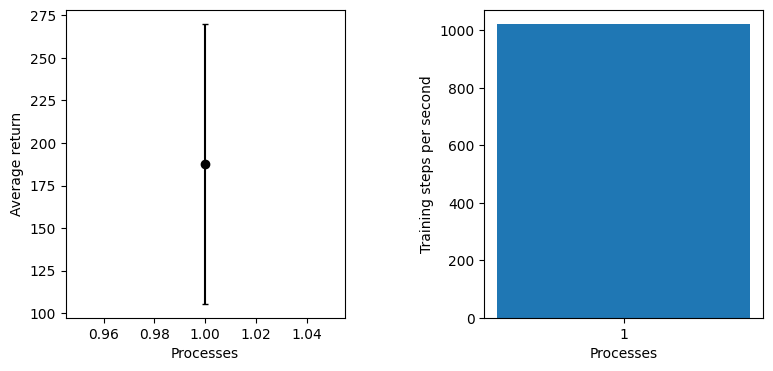

In [37]:
training_steps_per_second = [TRAIN_STEPS / t for t in training_times]

plot_training_results(training_steps_per_second, reward_averages, reward_std)

## 样本效率与挂钟时间的权衡
显然，样本效率、多样化经验和挂钟时间之间需要权衡。让我们尝试在固定时间内获得最佳性能，例如每次实验 10 秒

In [38]:
SECONDS_PER_EXPERIMENT = 10
steps_per_experiment = [int(SECONDS_PER_EXPERIMENT * fps) for fps in training_steps_per_second]
reward_averages = []
reward_std = []
training_times = []

for n_procs, train_steps in zip(PROCESSES_TO_TEST, steps_per_experiment):
    total_procs += n_procs
    print(f"Running for n_procs = {n_procs} for steps = {train_steps}")
    if n_procs == 1:
        # if there is only one process, there is no need to use multiprocessing
        train_env = DummyVecEnv([lambda: gym.make(env_id)])
    else:
        train_env = SubprocVecEnv([make_env(env_id, i+total_procs) for i in range(n_procs)], start_method="spawn")
        # Alternatively, you can use a DummyVecEnv if the communication delays is the bottleneck
        # train_env = DummyVecEnv([make_env(env_id, i+total_procs) for i in range(n_procs)])

    rewards = []
    times = []

    for experiment in range(NUM_EXPERIMENTS):
        # it is recommended to run several experiments due to variability in results
        train_env.reset()
        model = ALGO("MlpPolicy", train_env, verbose=0)
        start = time.time()
        model.learn(total_timesteps=train_steps)
        times.append(time.time() - start)
        mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
        rewards.append(mean_reward)

    train_env.close()
    reward_averages.append(np.mean(rewards))
    reward_std.append(np.std(rewards))
    training_times.append(np.mean(times))

Running for n_procs = 1 for steps = 10207


/home/codespace/.python/current/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


## 绘制结果

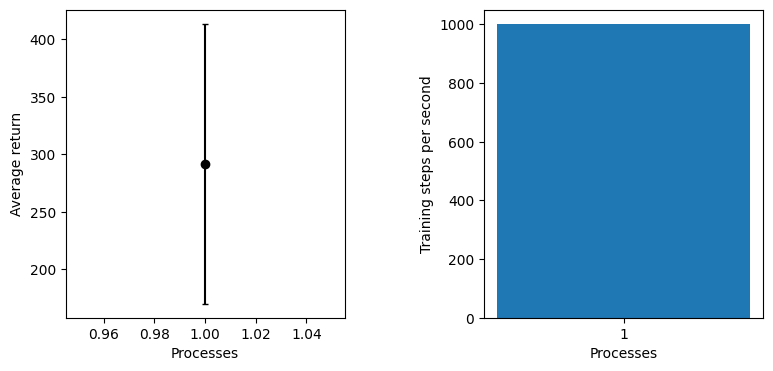

In [39]:
training_steps_per_second = [s / t for s,t in zip(steps_per_experiment, training_times)]

plot_training_results(training_steps_per_second, reward_averages, reward_std)

## DummyVecEnv vs SubprocVecEnv

In [41]:
reward_averages = []
reward_std = []
training_times = []
total_procs = 0
for n_procs in PROCESSES_TO_TEST:
    total_procs += n_procs
    print(f'Running for n_procs = {n_procs}')
    # Here we are using only one process even for n_env > 1
    # this is equivalent to DummyVecEnv([make_env(env_id, i + total_procs) for i in range(n_procs)])
    train_env = make_vec_env(env_id, n_envs=n_procs)

    rewards = []
    times = []

    for experiment in range(NUM_EXPERIMENTS):
        # it is recommended to run several experiments due to variability in results
        train_env.reset()
        model = ALGO("MlpPolicy", train_env, verbose=0)
        start = time.time()
        model.learn(total_timesteps=TRAIN_STEPS)
        times.append(time.time() - start)
        mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
        rewards.append(mean_reward)

    train_env.close()
    reward_averages.append(np.mean(rewards))
    reward_std.append(np.std(rewards))
    training_times.append(np.mean(times))

Running for n_procs = 1


/home/codespace/.python/current/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


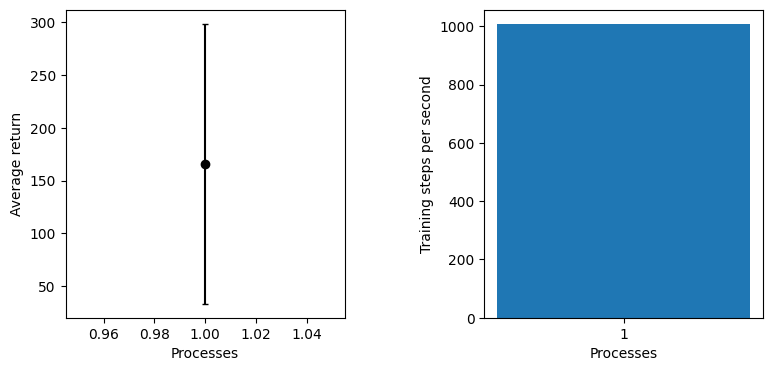

In [42]:
training_steps_per_second = [TRAIN_STEPS / t for t in training_times]

plot_training_results(training_steps_per_second, reward_averages, reward_std)